In [37]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import keras

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

In [38]:
print(os.getcwd())

/Users/wnowak/gitt/ffc/materialHardship


Set working directory to materialHardship folder.

In [39]:
os.chdir('/Users/wnowak/gitt/ffc/materialHardship/')

Import data needed for training and prediction.

In [ ]:
final_over_balanced =  pd.read_pickle('Data/balanced/final_over_balanced_decimals')

In [66]:
df_prediction = pd.read_pickle('Data/df_prediction')

In [40]:
final_over_balanced =  pd.read_pickle('Data/balanced/final_over_balanced_decimals')
medians =  pd.read_pickle('Data/median_impute_df_train_with_labels')

Split datasets into training and validation sets.

In [41]:
# split data into features and labels
def split_data(df, label='materialHardship'):
    copy = df.copy() # copy df so i dont alter original df by popping
    mh = copy.pop(label) # pop label
    x_train_bal, x_valid_bal, y_train_bal, y_valid_bal = train_test_split(copy, mh, test_size=0.1) #train test split
    return x_train_bal, x_valid_bal, y_train_bal, y_valid_bal # return


# In[8]:

x_tr_bal, _, y_tr_bal, _ = split_data(final_over_balanced)

x_tr, x_val, y_tr, y_val = split_data(medians)

In [180]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

X = x_tr.values
Y = y_tr/11
Y = Y.values

y_val = y_val/11

# # a baseline NN model function
# def baseline_model():
#     # create model
#     model = Sequential()
#     model.add(Dense(40, input_dim=x_tr.values.shape[1], kernel_initializer='normal', activation='relu'))
#     model.add(Dense(1, kernel_initializer='normal'))
#     # Compile model
#     model.compile(loss='mean_squared_error', optimizer='adam')
#     return model

# estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=30, verbose=1)

KFold, if you like:

In [179]:
# from sklearn.model_selection import KFold
# from sklearn.model_selection import cross_val_score

# seed = 7
# # fix random seed for reproducibility
# np.random.seed(seed)
# kfold = KFold(n_splits=2, random_state=seed)
# results = cross_val_score(estimator, X, Y, cv=kfold)
# print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [171]:
model = Sequential() # set up model

# add fully connected layer that go to num_nodes hidden nodes
num_nodes = 40
model.add(Dense(num_nodes, input_dim=x_tr.values.shape[1], kernel_initializer='normal', activation='relu'))

# use linear combination of weights and values from previous layer to make numeric prediction
model.add(Dense(1, kernel_initializer='normal'))

# minimize MSE
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

# fit the model for num_epochs epochs. callbacks option can be set to activate early stopping
# include validation_data to measure both
num_epochs = 300
fitt = model.fit( X, Y, batch_size=52, epochs=num_epochs, verbose=1, callbacks=None, validation_split=0.1, validation_data=(x_val.values,y_val.values), shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0)

Train on 1313 samples, validate on 146 samples
Epoch 1/300
1313/1313 [==============================] - 1s - loss: 8926929.7735 - acc: 0.0000e+00 - val_loss: 2994284.4144 - val_acc: 0.0000e+00

In [172]:
# determine which columns to use when making prediction
df_prediction_good_cols = df_prediction[x_tr.columns.values] # keep the columns that are in training data...

# use trained model to predict
preds  = model.predict(df_prediction_good_cols.values,verbose=1)

2752/2783 [============================>.] - ETA: 0s 

/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


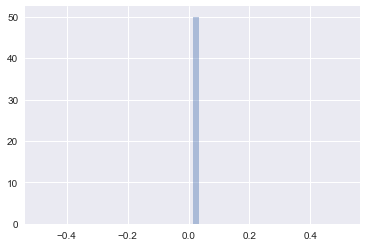

In [173]:
# check out distribution of predictions...
# model model is learning (losses decreasing) but predictions are always single-valued.
# WTF
sns.distplot(preds)
plt.show()

Below, I try to simply plot a pretty graph of the training and validation loss. You can see this in Figure A below, but I was having trouble changing y axis limit there, so I also played around with sns tsplot.

In [182]:
# fitt has history
hist_df = pd.DataFrame(fitt.history)
hist_df.head()

,acc,loss,val_acc,val_loss
0,0.000000,8.926930e+06,0.0,2.994284e+06
1,0.000000,1.255894e+06,0.0,1.626978e+06
2,0.000000,7.867361e+05,0.0,1.416598e+06
3,0.001523,5.606851e+05,0.0,1.214408e+06
4,0.000000,4.366843e+05,0.0,1.063270e+06


In [183]:
x = hist_df[['loss','val_loss']]
x.head()

,loss,val_loss
0,8.926930e+06,2.994284e+06
1,1.255894e+06,1.626978e+06
2,7.867361e+05,1.416598e+06
3,5.606851e+05,1.214408e+06
4,4.366843e+05,1.063270e+06


In [144]:
unstacked = pd.DataFrame(x.unstack())
unstacked.shape

(400, 1)

In [153]:
unstacked['losses'] = unstacked[0]
unstacked.head()

0 label        losses
loss 0  3.575099e+06  loss  3.575099e+06
     1  8.469168e+05  loss  8.469168e+05
     2  5.006040e+05  loss  5.006040e+05
     3  2.655716e+05  loss  2.655716e+05
     4  1.882859e+05  loss  1.882859e+05

In [145]:
loss = np.repeat('loss', 200)
val_loss = np.repeat('val_loss', 200)

In [150]:
labs = np.concatenate((loss,val_loss))

In [151]:
unstacked['label'] = labs

In [154]:
unstacked.head()

0 label        losses
loss 0  3.575099e+06  loss  3.575099e+06
     1  8.469168e+05  loss  8.469168e+05
     2  5.006040e+05  loss  5.006040e+05
     3  2.655716e+05  loss  2.655716e+05
     4  1.882859e+05  loss  1.882859e+05

In [155]:
unstacked = unstacked[['label','losses']]

In [156]:
# this is now a long dataframe 
# there are two values in label column - loss and val_loss
unstacked.head()

label        losses
loss 0  loss  3.575099e+06
     1  loss  8.469168e+05
     2  loss  5.006040e+05
     3  loss  2.655716e+05
     4  loss  1.882859e+05

UnboundLocalError: local variable 'x' referenced before assignment

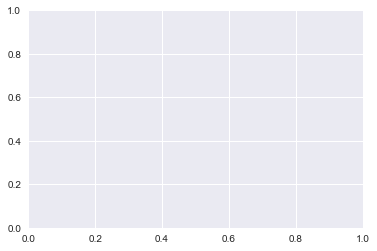

In [178]:
#wtf..still not working
sns.tsplot(data=unstacked[['label','losses']])
plt.show()

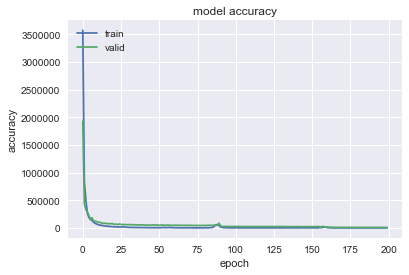

In [98]:
# summarize history for accuracy
plt.plot(fitt.history['loss'])
plt.plot(fitt.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# plt.set_ylim([0,100000])

# ax1 = plt.subplot(131)
# ax1.scatter([1, 2], [3, 4])
# ax1.set_xlim([0, 5])
# ax1.set_ylim([0, 5])